In [70]:
%load_ext autoreload
%autoreload 2

In [71]:
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
from jaxoptics import *
import matplotlib.pyplot as plt
import tqdm

In [253]:
def square(c0: float, n: float):
    def mode(x, y):
        return jnp.exp(-((x/c0)**n + (y/c0)**n))
    return mode

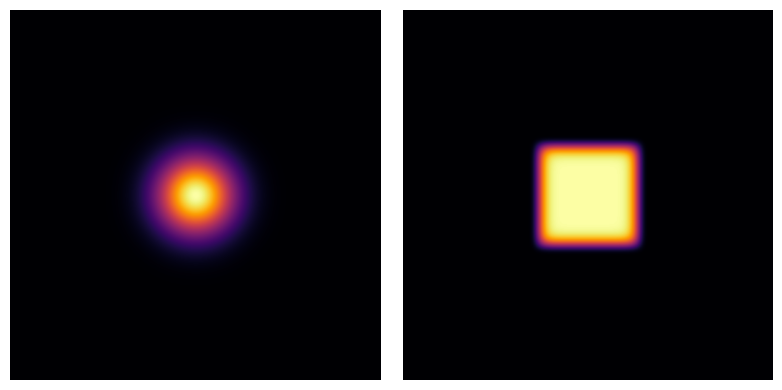

In [459]:
ns = (512, 512)
ds = (1.0, 1.0)
wavelength = 0.532

w0 = 75.0
cf = 75.0
n = 10

input_mode = generate_mode_stack([Gaussian(w0)], ns, ds)[1]
u0 = ScalarField(input_mode, ds, wavelength)
u0 = normalize_power(u0)

xv, yv = spatial_grid(ns, ds)
output_mode = square(cf, n)(xv, yv)
vf = ScalarField(output_mode, ds, wavelength)
vf = normalize_power(vf)

visualize_intensity(u0, vf)

In [531]:
z0 = 10000.0
z12 = 20000.0
p0 = ASProp(u0, z0, trainable=False)
p12 = RSProp(u0, z12, trainable=False)

phi1 = Phase(u0, trainable=True)
phi2 = Phase(u0, trainable=True)

system = OpticalSequence(p0, phi1, p12, phi2, p0)

In [532]:
def loss_fn(s, u, v):
    return jnp.sum(jnp.abs(s(u).electric - v.electric)**2)

@eqx.filter_jit
@eqx.filter_value_and_grad
def grad_fn(s, u, v):
    return loss_fn(s, u, v)

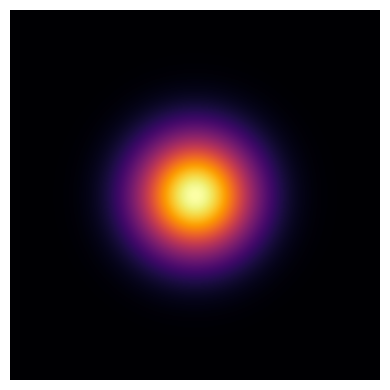

In [533]:
uf = system(u0)
visualize_intensity(uf)

In [534]:
no_optim = optax.set_to_zero()

def label_fn(s):
    if isinstance(s, OpticalSequence):  
        # Recursively apply label_fn on each layer while preserving structure
        return OpticalSequence(*map(label_fn, s.optical_components))
    elif isinstance(s, Phase):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "phase_mask")
        else:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "frozen")
    elif isinstance(s, ASProp) or isinstance(s, RSProp):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "prop_z"))
        else:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "frozen"))
    else:
        return jax.tree_at(lambda _: "frozen", s)

In [535]:
system = OpticalSequence(p0, phi1, p12, phi2, p0)  # Resets the system
losses = []

In [536]:
optim = optax.nadam(0.1)
tx = optax.transforms.partition({"phase_mask":optim, "frozen":no_optim}, label_fn)
opt_state = tx.init(system)

In [537]:
@jax.jit
def train_step(s, opt_state, u, v):
    loss, grads = grad_fn(s, u, v)
    updates, opt_state = tx.update(grads, opt_state)
    system = eqx.apply_updates(s, updates)
    return system, opt_state, loss

In [538]:
n_iter = 200
for i in tqdm.trange(n_iter, desc="Optimizing"):
    system, opt_state, loss = train_step(system, opt_state, u0, vf)
    losses.append(float(loss))

Optimizing: 100%|███████████████████████████████████████████████████████| 200/200 [00:00<00:00, 277.43it/s]


In [539]:
print(f"z12 = {system[2].z}")

z12 = [20000.]


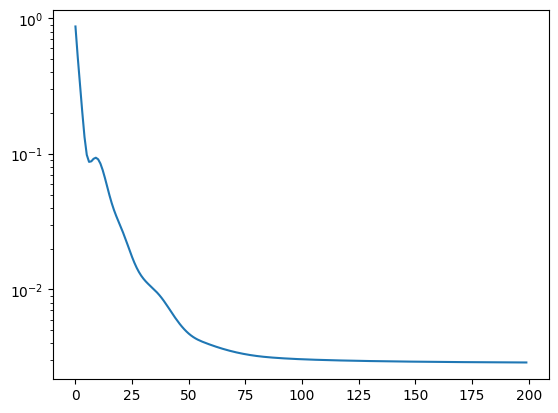

In [540]:
plt.figure()
plt.semilogy(losses)

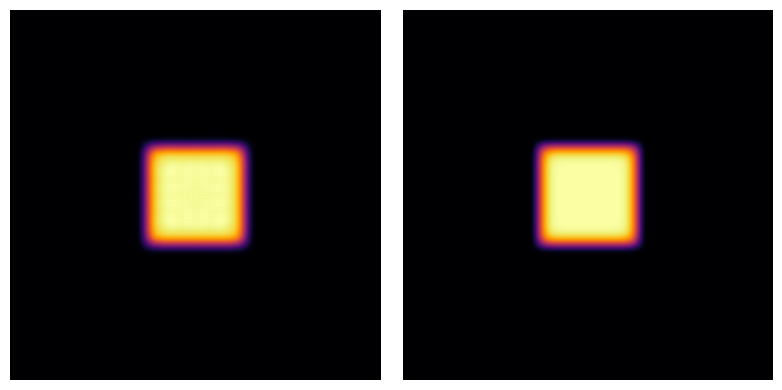

In [541]:
uf = system(u0)
visualize_intensity(uf, vf)

In [542]:
def extract_phase_masks(system):
    masks = [comp.phase() for comp in system.optical_components if isinstance(comp, Phase)]
    return jnp.stack(masks, axis=0) if masks else None

In [543]:
%matplotlib qt5
visualize_stack(extract_phase_masks(system), transform1=jnp.real, cmap1='twilight', cmap2='twilight')

In [544]:
plt.close('all')
%matplotlib inline